In [ ]:
!git clone https://github.com/MdAliAhnaf/frontal_3-category_face-mask_detection.git

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [ ]:
!pip install tensorflow==2.10.1 numpy==1.26.4 keras==2.10
!pip install retina-face opencv-python pyyaml h5py
!pip install tensorflow-io
!pip install -U albumentations

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [15]:
# Ensure GPU Memory Growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [16]:
# Define constants
resize = 224   #input image size
INIT_LR = 1e-4
EPOCHS = 50
BS = 64

dir_mask = '/kaggle/input/face-mask-dataset/FMD_DATASET/with_mask'
dir_inc_mask = '/kaggle/input/face-mask-dataset/FMD_DATASET/incorrect_mask'
dir_nomask = '/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask'
TRAIN_DIR = '/kaggle/input/face-mask-dataset/FMD_DATASET'

assert os.path.exists(dir_mask), 'Could not find ' + dir_mask
assert os.path.exists(dir_inc_mask), 'Could not find ' + dir_inc_mask
assert os.path.exists(dir_nomask), 'Could not find ' + dir_nomask

100%|██████████| 3/3 [00:00<00:00, 302.75it/s]
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


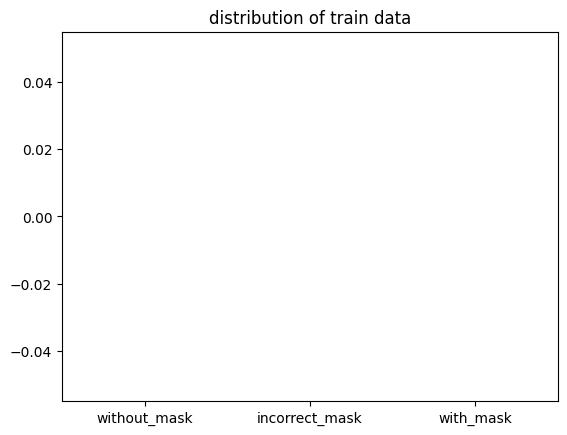

Total training examples: 0


In [17]:
# Kiểm tra phân bố dữ liệu
categories = []
class_count = []
train_exm = 0

# Lặp qua các thư mục con trong TRAIN_DIR để lấy số lượng tệp ảnh
for f in tqdm(os.listdir(TRAIN_DIR)):
    folder_path = os.path.join(TRAIN_DIR, f)
    if os.path.isdir(folder_path):  # Chỉ lấy thư mục con, tránh tệp
        file_count = sum(1 for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file)))
        categories.append(f)
        class_count.append(file_count)
        train_exm += file_count

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")
plt.show()
print(f"Total training examples: {train_exm}")

In [18]:
# Memory-efficient data loading function with batch processing
def load_data_in_batches(train_dir, categories, resize=224, batch_size=1000):
    data = []
    labels = []
    total_processed = 0
    
    for category in categories:
        path = os.path.join(train_dir, category)
        all_files = []
        
        # Collect all image paths
        for root, _, files in os.walk(path):
            for img in files:
                img_path = os.path.join(root, img)
                if os.path.isfile(img_path):
                    all_files.append(img_path)
        
        # Process in batches
        for i in range(0, len(all_files), batch_size):
            batch_files = all_files[i:i+batch_size]
            batch_data = []
            batch_labels = []
            
            for img_path in tqdm(batch_files, desc=f"Loading {category} batch {i//batch_size + 1}"):
                try:
                    # Efficient image loading with error handling
                    image = Image.open(img_path)
                    
                    # Convert to RGB (3 channels) instead of RGBA (4 channels) to save memory
                    if image.mode != 'RGB':
                        image = image.convert('RGB')
                    
                    # Resize and preprocess
                    image = image.resize((resize, resize))
                    image = img_to_array(image)
                    image = preprocess_input(image)
                    
                    batch_data.append(image)
                    batch_labels.append(category)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue
            
            # Append batch to main arrays
            if batch_data:
                data.extend(batch_data)
                labels.extend(batch_labels)
                total_processed += len(batch_data)
                print(f"Processed {total_processed} images so far")
                
                # Force garbage collection to free memory
                gc.collect()
    
    # Convert to numpy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    
    return data, labels

In [19]:
# Load data with memory optimization
print("Loading dataset in batches to optimize memory usage...")
data, labels = load_data_in_batches(TRAIN_DIR, categories, resize=resize, batch_size=1000)

# Check dataset size and distribution
print(f"Total images loaded: {len(data)}")
unique, counts = np.unique(labels, return_counts=True)
distribution = dict(zip(unique, counts))
print(f"Class distribution: {distribution}")

Loading dataset in batches to optimize memory usage...


Loading without_mask batch 1: 100%|██████████| 1000/1000 [00:06<00:00, 161.78it/s]


Processed 1000 images so far


Loading without_mask batch 2: 100%|██████████| 1000/1000 [00:06<00:00, 163.53it/s]


Processed 2000 images so far


Loading without_mask batch 3: 100%|██████████| 1000/1000 [00:06<00:00, 159.71it/s]


Processed 3000 images so far


Loading without_mask batch 4: 100%|██████████| 1000/1000 [00:06<00:00, 154.96it/s]


Processed 4000 images so far


Loading without_mask batch 5: 100%|██████████| 747/747 [00:06<00:00, 121.74it/s]


Processed 4747 images so far


Loading incorrect_mask batch 1: 100%|██████████| 1000/1000 [00:22<00:00, 44.29it/s]


Processed 5747 images so far


Loading incorrect_mask batch 2: 100%|██████████| 1000/1000 [00:23<00:00, 43.48it/s]


Processed 6747 images so far


Loading incorrect_mask batch 3: 100%|██████████| 1000/1000 [00:22<00:00, 43.79it/s]


Processed 7747 images so far


Loading incorrect_mask batch 4: 100%|██████████| 1000/1000 [00:21<00:00, 45.72it/s]


Processed 8747 images so far


Loading incorrect_mask batch 5: 100%|██████████| 1000/1000 [00:22<00:00, 44.46it/s]


Processed 9747 images so far


Loading with_mask batch 1: 100%|██████████| 1000/1000 [00:18<00:00, 54.06it/s]


Processed 10747 images so far


Loading with_mask batch 2:  83%|████████▎ | 832/1000 [00:14<00:03, 55.11it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Loading with_mask batch 2: 100%|██████████| 1000/1000 [00:17<00:00, 57.59it/s]


Processed 11747 images so far


Loading with_mask batch 3: 100%|██████████| 1000/1000 [00:18<00:00, 53.01it/s]


Processed 12747 images so far


Loading with_mask batch 4: 100%|██████████| 1000/1000 [00:18<00:00, 52.87it/s]


Processed 13747 images so far


Loading with_mask batch 5: 100%|██████████| 789/789 [00:07<00:00, 102.82it/s]


Processed 14536 images so far
Total images loaded: 14536
Class distribution: {'incorrect_mask': 5000, 'with_mask': 4789, 'without_mask': 4747}


In [20]:
# Encode labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(f"Label shape after encoding: {labels.shape}")

# Data augmentation
AugmentedData = ImageDataGenerator(
    zoom_range=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Label shape after encoding: (14536, 3)


In [21]:
# Load and configure base model
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Construct the head model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# Create the complete model
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the base model layers
for layer in baseModel.layers:
    layer.trainable = False

In [22]:
# Split data with stratification
print("Splitting data into training and testing sets...")
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.2, stratify=labels, random_state=42)

print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")

# Free memory after split
del data
del labels
gc.collect()

Splitting data into training and testing sets...
Shape of x_train: (11628, 224, 224, 3)
Shape of y_train: (11628, 3)
Shape of x_test: (2908, 224, 224, 3)
Shape of y_test: (2908, 3)


706

In [23]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Compile the model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] compiling model...\n[INFO] training head...")

# Train the model with batch generator to save memory
H = model.fit(
    AugmentedData.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/50
181/181 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9059
Epoch 1: val_loss improved from inf to 0.12307, saving model to best_model.h5
181/181 [==============================] - 138s 709ms/step - loss: 0.2637 - accuracy: 0.9059 - val_loss: 0.1231 - val_accuracy: 0.9591
Epoch 2/50
181/181 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9563
Epoch 2: val_loss improved from 0.12307 to 0.09988, saving model to best_model.h5
181/181 [==============================] - 122s 674ms/step - loss: 0.1323 - accuracy: 0.9563 - val_loss: 0.0999 - val_accuracy: 0.9670
Epoch 3/50
181/181 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9667
Epoch 3: val_loss did not improve from 0.09988
181/181 [==============================] - 122s 676ms/step - loss: 0.1055 - accuracy: 0.9667 - val_loss: 0.1030 - val_accuracy: 0.9656
Epoch 4/50
181/181 [==============================

[INFO] evaluating network...
46/46 [==============================] - 4s 83ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1000
           1       0.97      0.99      0.98       958
           2       0.98      0.98      0.98       950

    accuracy                           0.98      2908
   macro avg       0.98      0.98      0.98      2908
weighted avg       0.98      0.98      0.98      2908



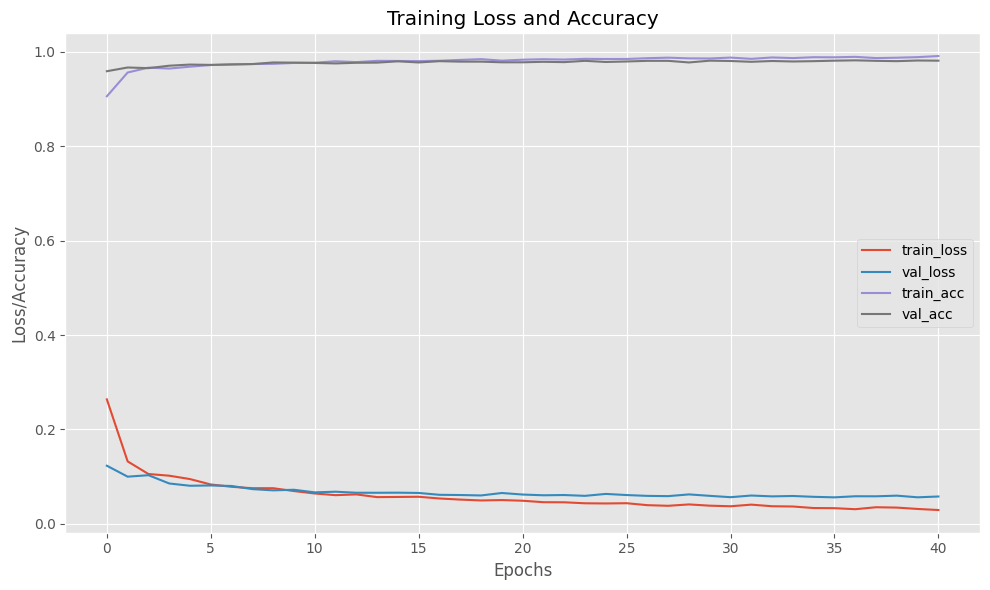

[INFO] Model saved successfully


In [24]:
# Evaluate the model
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# Show classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

# Plot training history
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(10, 6))

plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Save the model
model.save("my_mask_detector_1.h5")
print("[INFO] Model saved successfully")